# Modeling a High Resolution Reflection Spectrum

Hajime Kawahara October 2nd (2024)

This code analyzes the reflection spectrum of Jupiter. We here try to solve two problems.
One is we need to calibrate the wavenumber grid of the data because the calibration lines were insufficient and the wavelength of the data is not accurate.
To do so, we use the reflection spectrum model itself. 
The other is, after the wavelenghtcalibration, we try to fit the model to the calibrated data.

This note corresponds to the former one. For the latter, check "Jupiter_Hires_Modeling_NIR_fitting.ipynb"

In [1]:
from jax import config
config.update("jax_enable_x64", False)


Forget about the following code. I need this to run the code somewhere...

In [2]:

#username="exoplanet01"
username="kawahara"
if username == "exoplanet01":
    import ssl
    ssl._create_default_https_context = ssl._create_unverified_context



We need to get `JoviSpec`, the repository that contains the real reflection spectra of Jupiter. 

```sh
git clone https://github.com/HajimeKawahara/jovispec.git
python setup.py install
```


/home/kawahara/anaconda3/envs/myenv39/lib/python3.9/site-packages/JoviSpec-0.1-py3.9.egg/jovispec/abcio.py:18: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  dat = pd.read_csv(


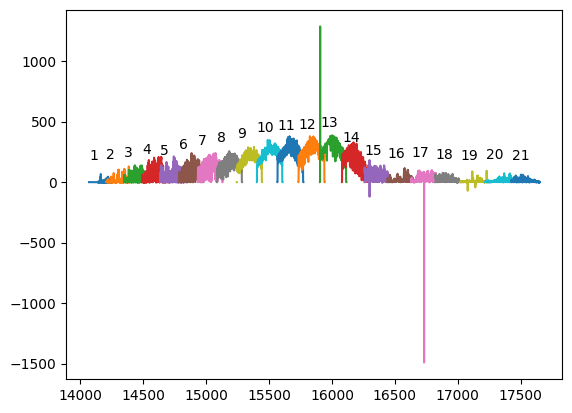

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from jovispec.abcio import read_irddat

uncalwav, spec, order = read_irddat("/home/"+username+"/jovispec/analysis/data/H/reduc/nw8034325_mmf12.dat")

for iorder in range(1,np.max(order)+1):
    mask = order==iorder
    plt.plot(uncalwav[mask], spec[mask])
    plt.text(np.min(uncalwav[mask]), np.nanmean(spec[mask])+180, str(iorder))



In [4]:
# the target order = 14, but we need neighboring orders.

mask = (order == 14) | (order == 13) | (order == 15)    
uwav_order = []
spec_order = []
wavelength_start = []
wavelength_end = []
for iorder in range(13,16):
    mask = order==iorder
    uwav_order.append(uncalwav[mask][::-1])
    spec_order.append(spec[mask][::-1])
    wavelength_start.append(np.min(uwav_order)-10.0)    # AA
    wavelength_end.append(np.max(uwav_order)+10.0)    # AA  
#uwav_order = uncalwav[mask][::-1]
#spec_order = spec[mask][::-1] 


Sets the wavelength range

/tmp/ipykernel_818875/3887790191.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


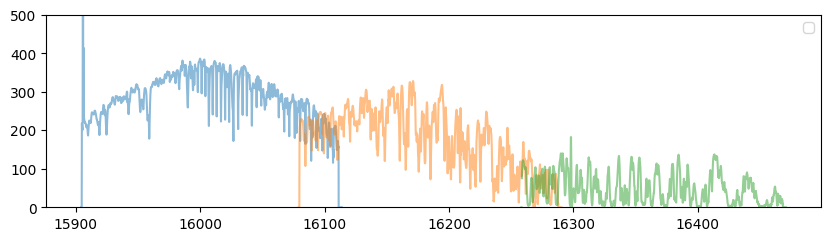

In [5]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,2.5))
ax = fig.add_subplot(111)
for i in range(3):
    ax.plot(uwav_order[i], spec_order[i],alpha=0.5)
#plt.xlim(wavelength_start,wavelength_end)
plt.ylim(0,500)
plt.legend()
plt.show()

In [6]:
from exojax.spec.unitconvert import wav2nu
unus_order = []
for i in range(3):  
    unus_order.append(wav2nu(uwav_order[i],unit="AA"))


2024-10-02 14:33:07.185843: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.6.20). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


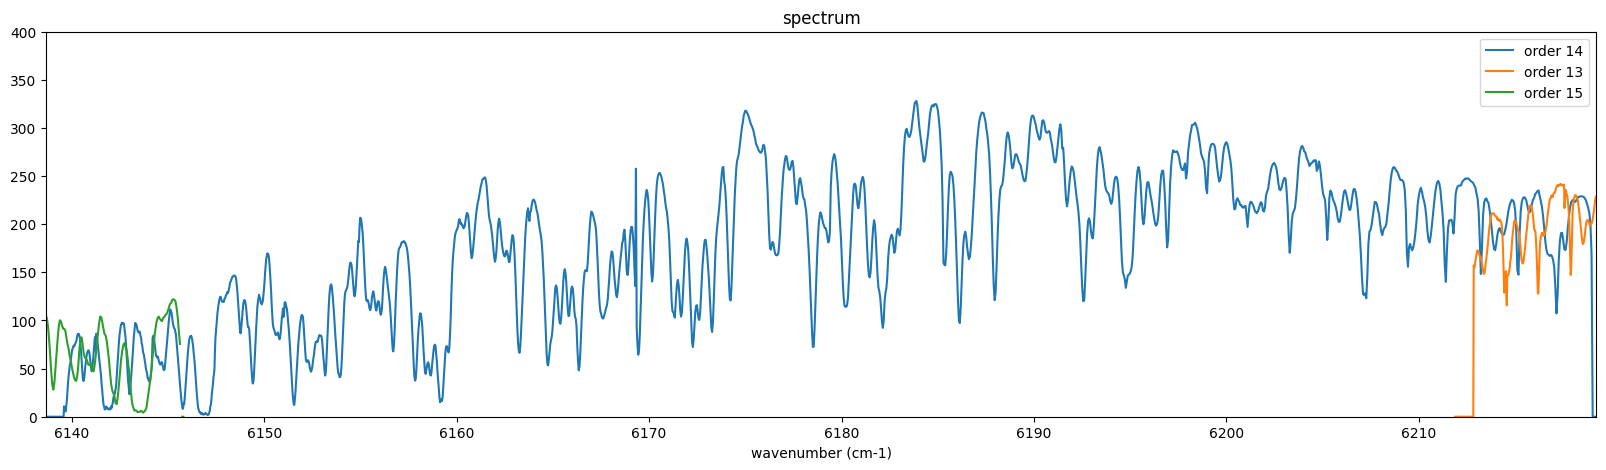

In [7]:
fig = plt.figure(figsize=(20,5))
plt.plot(unus_order[1],spec_order[1], label="order 14")
plt.xlim(np.min(unus_order[1]),np.max(unus_order[1]))         
plt.plot(unus_order[0]+6,spec_order[0], label="order 13")
plt.plot(unus_order[2]-5,spec_order[2], label="order 15")
plt.ylim(0,400)
plt.xlabel("wavenumber (cm-1)")
plt.legend()
plt.title("spectrum")
plt.savefig("spectrum.png")
plt.show()

The following spectrum is the target we will analyze (the center part of Jupiter)!

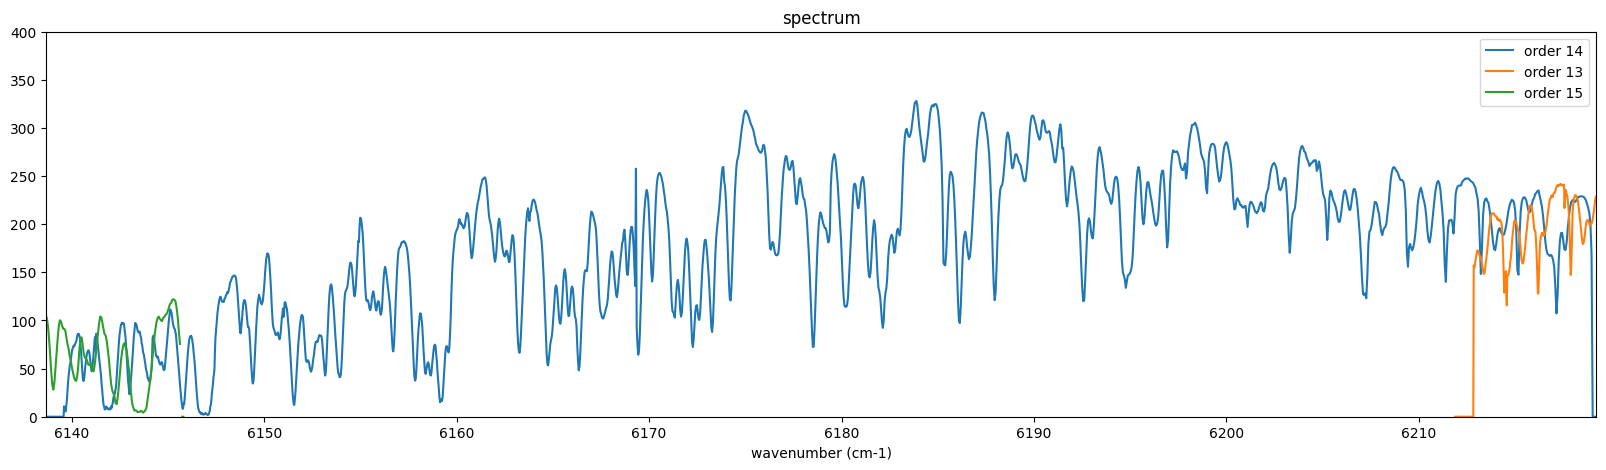

In [8]:
fig = plt.figure(figsize=(20,5))
plt.plot(unus_order[1],spec_order[1], label="order 14")
plt.xlim(np.min(unus_order[1]),np.max(unus_order[1]))         
plt.plot(unus_order[0]+6,spec_order[0], label="order 13")
plt.plot(unus_order[2]-5,spec_order[2], label="order 15")
plt.ylim(0,400)
plt.xlabel("wavenumber (cm-1)")
plt.legend()
plt.title("spectrum")
plt.show()

We use a non-overlapped region in the order 14 to avoid complexity.

In [9]:
istart = np.searchsorted(unus_order[1],6148)
iend = np.searchsorted(unus_order[1],6205)


/home/kawahara/exojax/src/exojax/spec/unitconvert.py:63: UserWarning: Both input wavelength and output wavenumber are in ascending order.
  warnings.warn(


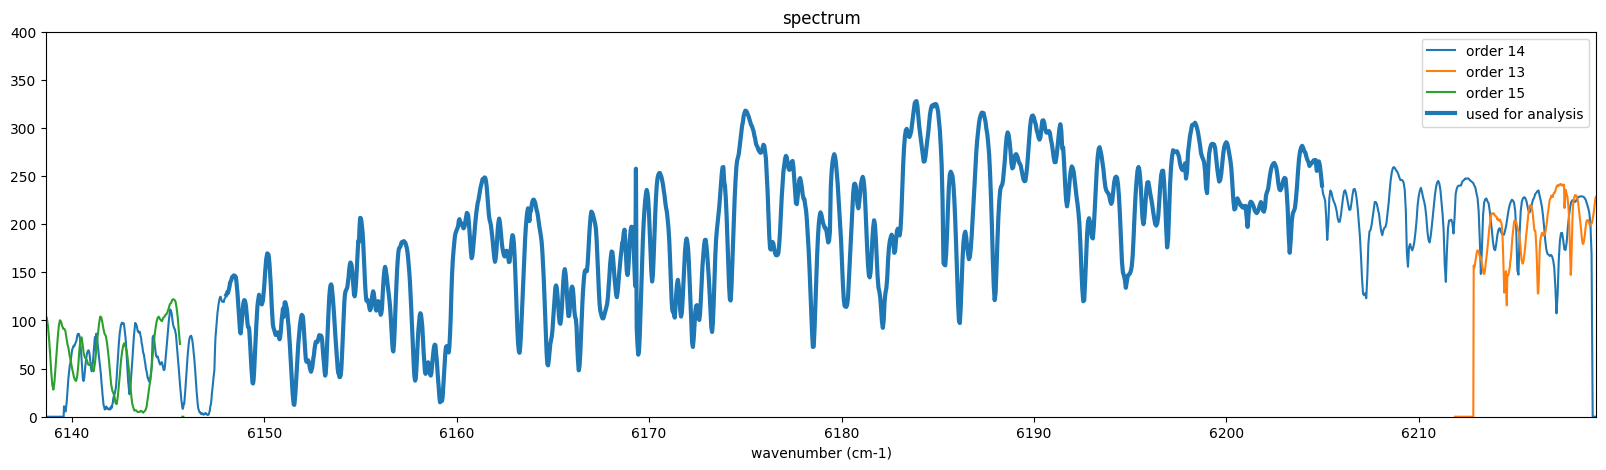

In [10]:

from exojax.spec.unitconvert import wav2nu
unus_analysis = unus_order[1][istart:iend]
spec_analysis = spec_order[1][istart:iend]
uwav_analysis = wav2nu(unus_analysis,unit="AA")
wavelength_start_analysis = np.min(uwav_analysis)-10.0 #AA
wavelength_end_analysis = np.max(uwav_analysis)+10.0 #AA

fig = plt.figure(figsize=(20,5))
plt.plot(unus_order[1],spec_order[1], label="order 14")
plt.xlim(np.min(unus_order[1]),np.max(unus_order[1]))         
plt.plot(unus_order[0]+6,spec_order[0], label="order 13")
plt.plot(unus_order[2]-5,spec_order[2], label="order 15")
plt.plot(unus_analysis,spec_analysis, label="used for analysis", color="C0", lw=3)

plt.ylim(0,400)
plt.xlabel("wavenumber (cm-1)")
plt.legend()
plt.title("spectrum")
plt.show()

### Telluric

Telluric lines stuff... ExoJAX can do that anyway.

In [11]:
from exojax.spec.api import MdbHitran
from exojax.spec.opacalc import OpaDirect
from exojax.spec.opacalc import OpaPremodit
from exojax.utils.grids import wavenumber_grid
from exojax.spec.unitconvert import wav2nu

N = 40000

margin = 0.0  # cm-1
nus_start = wav2nu(wavelength_end_analysis, unit="AA") - margin
nus_end = wav2nu(wavelength_start_analysis, unit="AA") + margin

mdb_water = MdbHitran("H2O", nurange=[nus_start, nus_end], isotope=1)
nus, wav, res = wavenumber_grid(nus_start, nus_end, N, xsmode="lpf", unit="cm-1")
opa_telluric = OpaPremodit(mdb_water, nu_grid=nus, allow_32bit=True, auto_trange=[80.0, 400.0])

radis engine =  vaex
Using /home/kawahara/exojax/documents/tutorials/jupiters/downloads__can_be_deleted/H2O


Data is fetched from http://hitran.org

BEGIN DOWNLOAD: H2O_1
  65536 bytes written to /home/kawahara/exojax/documents/tutorials/jupiters/downloads__can_be_deleted/H2O/H2O_1.data
  65536 bytes written to /home/kawahara/exojax/documents/tutorials/jupiters/downloads__can_be_deleted/H2O/H2O_1.data
  65536 bytes written to /home/kawahara/exojax/documents/tutorials/jupiters/downloads__can_be_deleted/H2O/H2O_1.data
  65536 bytes written to /home/kawahara/exojax/documents/tutorials/jupiters/downloads__can_be_deleted/H2O/H2O_1.data
  65536 bytes written to /home/kawahara/exojax/documents/tutorials/jupiters/downloads__can_be_deleted/H2O/H2O_1.data
  65536 bytes written to /home/kawahara/exojax/documents/tutorials/jupiters/downloads__can_be_deleted/H2O/H2O_1.data
  65536 bytes written to /home/kawahara/exojax/documents/tutorials/jupiters/downloads__can_be_deleted/H2O/H2O_1.data
  65536 b

/home/kawahara/exojax/src/exojax/utils/jaxstatus.py:19: UserWarning: JAX is 32bit mode. We recommend to use 64bit mode. 
You can change to 64bit mode by writing 

    from jax import config 
    config.update("jax_enable_x64", True)

  warnings.warn(msg+how_change_msg)


# of reference width grid :  17
# of temperature exponent grid : 5


uniqidx: 100%|██████████| 25/25 [00:00<00:00, 35690.13it/s]

Premodit: Twt= 328.42341041740974 K Tref= 91.89455622053987 K
Making LSD:|--------------------| 0%

Making LSD:|####################| 100%


Yes ah no, almost no telluric line confirmed...

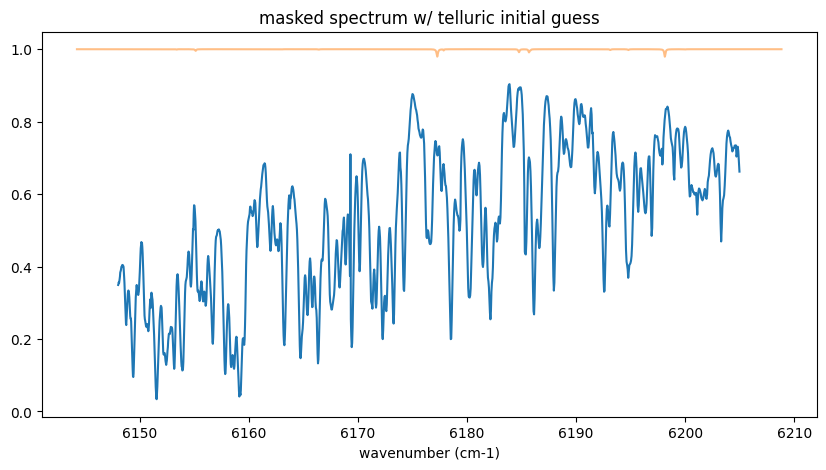

In [12]:
import jax.numpy as jnp

T = 200.0
P = 0.5
xsv = opa_telluric.xsvector(T, P)
nl = 1.0e22
a = 1.0

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
plt.title("masked spectrum w/ telluric initial guess")
plt.plot(unus_analysis, spec_analysis/np.median(spec_analysis)/2.0, label="masked spectrum")
#plt.ylim(0.0, 0.7)
plt.plot(nus, a * jnp.exp(-nl * xsv), alpha=0.5)
# plt.xlim(1.e8/wavelength_start, 1.e8/wavelength_end)
plt.xlabel("wavenumber (cm-1)")

plt.show()

## Solar spectrum

This is the reflected "solar" spectrum by Jupiter! So, we need the solar spectrum template.

I found very good one: High-resolution solar spectrum taken from Meftar et al. (2023) 

- 10.21413/SOLAR-HRS-DATASET.V1.1_LATMOS
- http://doi.latmos.ipsl.fr/DOI_SOLAR_HRS.v1.1.html
- http://bdap.ipsl.fr/voscat_en/solarspectra.html


In [13]:

import pandas as pd
#filename = "/home/kawahara/solar-hrs/Spectre_HR_LATMOS_Meftah_V1.txt"
filename = "/home/"+username+"/solar-hrs/Spectre_HR_LATMOS_Meftah_V1.txt"
dat = pd.read_csv(filename, names=("wav","flux"), comment=";", delimiter="\t")
dat["wav"] = dat["wav"]*10

wav_solar = dat["wav"][::-1]
solspec = dat["flux"][::-1]
nus_solar = wav2nu(wav_solar,unit="AA")


This is really the solar spectrum reflected by something...

Text(0.5, 0, 'wavenumber (cm-1)')

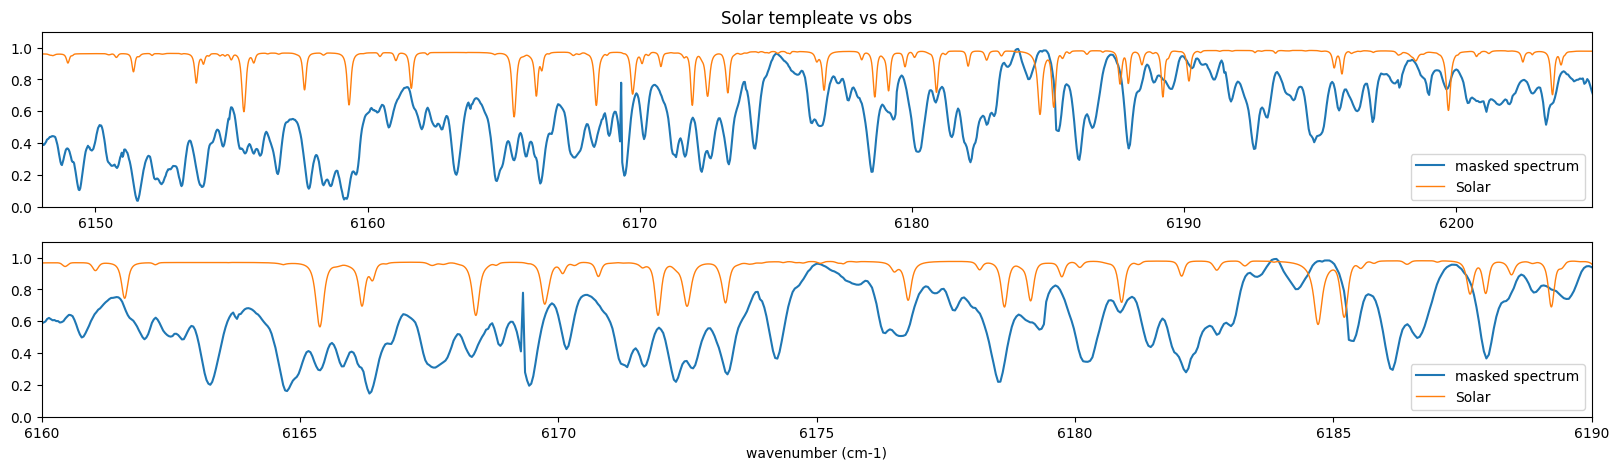

In [14]:
vrv = 10.0
vperc = vrv/300000

fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(211)
plt.plot(unus_order[1],spec_order[1]/np.median(spec_order[1])/2.0, label="masked spectrum")
plt.plot(nus_solar*(1.0+vperc),solspec*4,lw=1,label="Solar")
plt.xlim(np.min(unus_analysis),np.max(unus_analysis))
plt.ylim(0.0,1.1)

plt.legend()
plt.title("Solar templeate vs obs")
ax = fig.add_subplot(212)
plt.plot(unus_order[1],spec_order[1]/np.median(spec_order[1])/2.0, label="masked spectrum")
plt.plot(nus_solar*(1.0+vperc),solspec*4,lw=1,label="Solar")
plt.xlim(np.min(unus_analysis),np.max(unus_analysis))
plt.ylim(0.0,1.1)
plt.xlim(6160,6190)
plt.legend()
plt.xlabel("wavenumber (cm-1)")


## Atmospheric Model Setting

See `Jupiter_cloud_model_using_amp.ipynb` 


/home/kawahara/exojax/src/exojax/spec/dtau_mmwl.py:13: FutureWarning: dtau_mmwl might be removed in future.
  warnings.warn("dtau_mmwl might be removed in future.", FutureWarning)


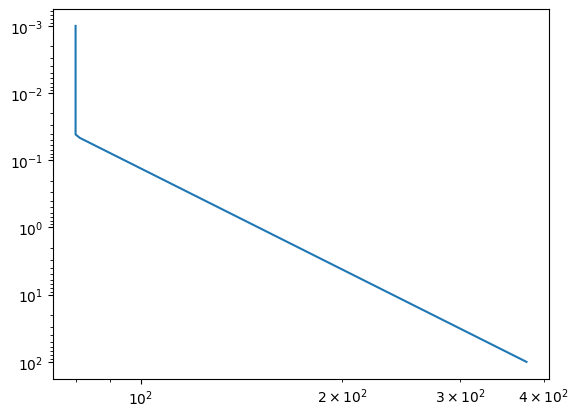

In [15]:
from exojax.spec.atmrt import ArtReflectPure
from exojax.utils.astrofunc import gravity_jupiter


art = ArtReflectPure(nu_grid=nus, pressure_btm=1.0e2, pressure_top=1.0e-3, nlayer=100)
art.change_temperature_range(80.0, 400.0)
Tarr = art.powerlaw_temperature(150.0, 0.2)
Parr = art.pressure

mu = 2.3  # mean molecular weight
gravity = gravity_jupiter(1.0, 1.0)

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(Tarr, art.pressure)
ax.invert_yaxis()
plt.yscale("log")
plt.xscale("log")
plt.show()

In [19]:
from exojax.spec.pardb import PdbCloud
from exojax.atm.atmphys import AmpAmcloud

pdb_nh3 = PdbCloud("NH3")
amp_nh3 = AmpAmcloud(pdb_nh3, bkgatm="H2")
amp_nh3.check_temperature_range(Tarr)

# condensate substance density
rhoc = pdb_nh3.condensate_substance_density  # g/cc

from exojax.utils.zsol import nsol
from exojax.atm.atmconvert import vmr_to_mmr
from exojax.spec.molinfo import molmass_isotope

n = nsol()  # solar abundance
abundance_nh3 = n["N"]
molmass_nh3 = molmass_isotope("NH3", db_HIT=False)

fsed = 10.0
sigmag = 2.0
Kzz = 1.0e4
MMRbase_nh3 = vmr_to_mmr(abundance_nh3, molmass_nh3, mu)

rg_layer, MMRc = amp_nh3.calc_ammodel(
    Parr, Tarr, mu, molmass_nh3, gravity, fsed, sigmag, Kzz, MMRbase_nh3
)

.database/particulates/virga/virga.zip  exists. Remove it if you wanna re-download and unzip.
Refractive index file found:  .database/particulates/virga/NH3.refrind
Miegrid file exists: .database/particulates/virga/miegrid_lognorm_NH3.mg.npz
Database for solar abundance =  AAG21
Asplund, M., Amarsi, A. M., & Grevesse, N. 2021, arXiv:2105.01661


/home/kawahara/exojax/src/exojax/atm/atmphys.py:54: UserWarning: min temperature 80.0 K is smaller than min(vfactor t range) 179.10000610351562 K
  warnings.warn(


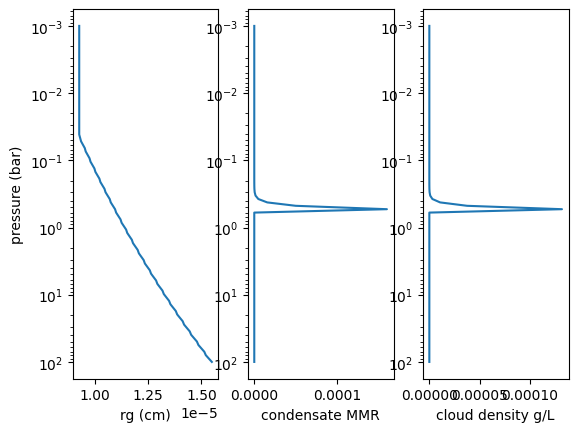

In [20]:
import matplotlib.pyplot as plt

# to convert MMR to g/L ... 
from exojax.atm.idealgas import number_density
from exojax.utils.constants import m_u
fac = molmass_nh3*m_u*number_density(Parr,Tarr)*1.e3 #g/L 

fig = plt.figure()
ax = fig.add_subplot(131)
plt.plot(rg_layer, Parr)
plt.xlabel("rg (cm)")
plt.ylabel("pressure (bar)")
plt.yscale("log")
ax.invert_yaxis()
ax = fig.add_subplot(132)
plt.plot(MMRc, Parr)
plt.xlabel("condensate MMR")
plt.yscale("log")
#plt.xscale("log")
ax.invert_yaxis()
ax = fig.add_subplot(133)
plt.plot(fac*MMRc, Parr)
plt.xlabel("cloud density g/L")
plt.yscale("log")
#plt.xscale("log")
ax.invert_yaxis()

In [21]:
rg = 1.0e-5

from exojax.spec.opacont import OpaMie

opa = OpaMie(pdb_nh3, nus)
# sigma_extinction, sigma_scattering, asymmetric_factor = opa.mieparams_vector(rg,sigmag) # if using MieGrid
sigma_extinction, sigma_scattering, asymmetric_factor = (
    opa.mieparams_vector_direct_from_pymiescatt(rg, sigmag)
)

100%|██████████| 3/3 [00:01<00:00,  2.80it/s]


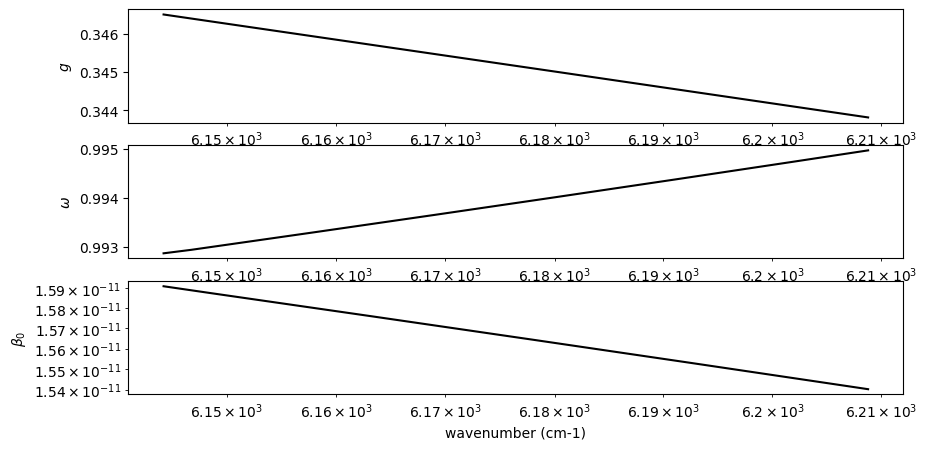

In [22]:
# plt.plot(pdb_nh3.refraction_index_wavenumber, miepar[50,:,0])
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(311)
plt.plot(nus, asymmetric_factor, color="black")
plt.xscale("log")
plt.ylabel("$g$")
ax = fig.add_subplot(312)
plt.plot(
    nus,
    sigma_scattering / sigma_extinction,
    label="single scattering albedo",
    color="black",
)
plt.xscale("log")
plt.ylabel("$\\omega$")
ax = fig.add_subplot(313)
plt.plot(nus, sigma_extinction, label="ext", color="black")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("wavenumber (cm-1)")
plt.ylabel("$\\beta_0$")
plt.savefig("miefig_high.png")

Next, we consider the gas component, i.e. methane

In [23]:
from exojax.spec.api import MdbHitemp

Ignore the following unless you are interested in the elower max optimization

In [24]:
optimize = False #if you want to run the elower maximum optimization, turn True
if optimize:
    mdb = MdbHitemp("CH4", nurange=[nus_start,nus_end], isotope=1)
    from exojax.spec.optgrid import optelower
    Tmax = 400.0
    Pmin = 1.e-5
    Eopt = optelower(mdb, nus, Tmax, Pmin)

Oh, we need HITEMP because our observation is in visible band, i.e., we need higher energy states.

In [25]:
Eopt = 3300.0 # this is from the above optimization result
#mdb_reduced = MdbHitemp("CH4", nurange=[nus_start,nus_end], isotope=1, elower_max=Eopt)
mdb_reduced = MdbHitemp("CH4", nurange=[nus_start,nus_end], isotope=1, elower_max=Eopt)

radis engine =  vaex


The optimization stuff, ignore

In [26]:
if optimize:
    plt.plot(mdb.elower,mdb.line_strength_ref,".",alpha=0.3)
    plt.plot(mdb_reduced.elower,mdb_reduced.line_strength_ref,".",alpha=0.5,color="C2")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("E lower (cm-1)")
    plt.ylabel("line strength at T="+str(mdb.Tref)+"K")
    plt.axvline(Eopt, color="C2")

In [27]:
opa = OpaPremodit(mdb_reduced, nu_grid=nus, allow_32bit=True, auto_trange=[80.0, 300.0]) #this reduced the device memory use in 5/6.
#opa = OpaPremodit(mdb, nu_grid=nus, allow_32bit=True, auto_trange=[80.0, 300.0]) #this reduced the device memory use in 5/6.

/home/kawahara/exojax/src/exojax/utils/jaxstatus.py:19: UserWarning: JAX is 32bit mode. We recommend to use 64bit mode. 
You can change to 64bit mode by writing 

    from jax import config 
    config.update("jax_enable_x64", True)

  warnings.warn(msg+how_change_msg)


OpaPremodit: params automatically set.
default elower grid trange (degt) file version: 2
Robust range: 79.45501192821337 - 740.1245313998245 K
OpaPremodit: Tref_broadening is set to  154.91933384829665 K
OpaPremodit: gamma_air and n_air are used. gamma_ref = gamma_air/Patm
# of reference width grid :  7
# of temperature exponent grid : 4


uniqidx: 100%|██████████| 8/8 [00:00<00:00, 1108.39it/s]

Premodit: Twt= 328.42341041740974 K Tref= 91.89455622053987 K
Making LSD:|--------------------| 0%

Making LSD:|####################| 100%


### cloud opacity

In [28]:
dtau_cld = art.opacity_profile_cloud_lognormal(sigma_extinction, rhoc, MMRc, rg, sigmag, gravity)

### gas opacity 

In [29]:
mmr_ch4 = art.constant_mmr_profile(0.010) # (*_*)/~
molmass_ch4 = molmass_isotope("CH4", db_HIT=False)

xsmatrix = opa.xsmatrix(Tarr,Parr)
dtau_ch4 = art.opacity_profile_xs(xsmatrix, mmr_ch4,molmass_ch4,gravity)

In [30]:
dtau_cld_scat = art.opacity_profile_cloud_lognormal(sigma_scattering, rhoc, MMRc, rg, sigmag, gravity)
single_scattering_albedo = (dtau_cld_scat)/(dtau_cld + dtau_ch4)

sigma_scattering[None,:]/sigma_extinction[None,:] + np.zeros((len(art.pressure), len(nus)))
asymmetric_parameter = asymmetric_factor + np.zeros((len(art.pressure), len(nus))) 
reflectivity_surface = np.zeros(len(nus))

In [31]:
dtau = dtau_cld + dtau_ch4

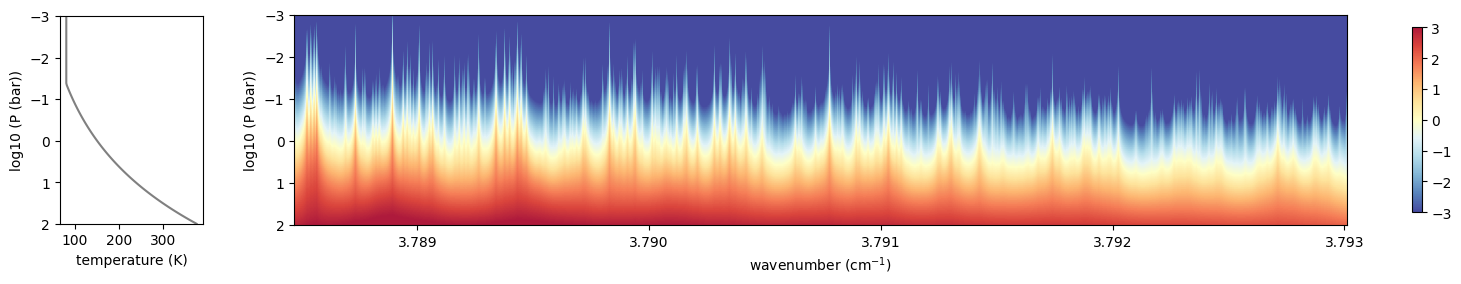

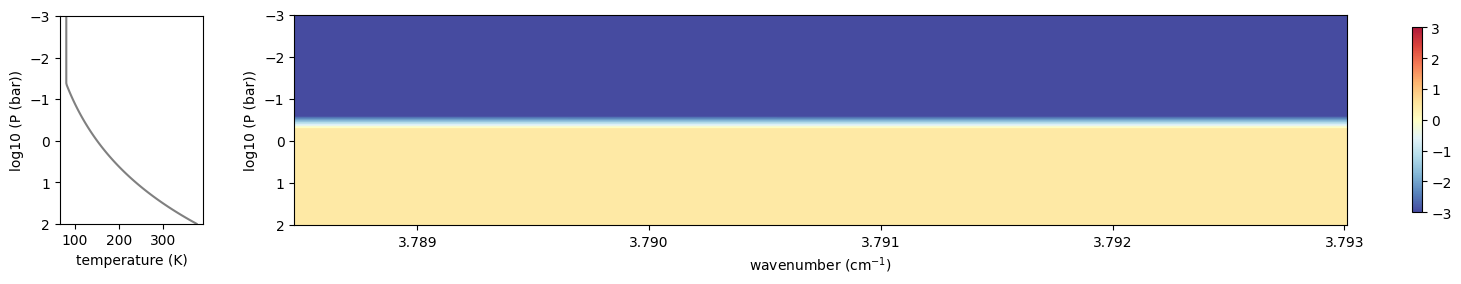

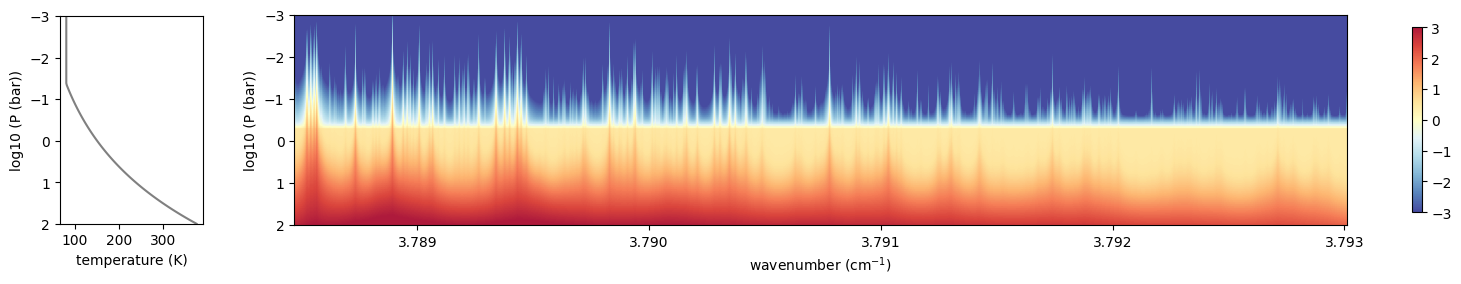

In [32]:
from exojax.plot.atmplot import plottau

plottau(np.log10(nus), dtau_ch4, Tarr, Parr)
plt.show()
plottau(np.log10(nus), dtau_cld, Tarr, Parr)
plt.show()
plottau(np.log10(nus), dtau, Tarr, Parr)

OK, uses the solar spectrum as an incomning spectrum! 

In [93]:
# solar vs jupiter
vrv = 0.0
#vrv = -5.0
vperc = vrv/300000

#vv = -60.0
vv = -57.0
vpercp = (vrv + vv) / 300000

vpercp_only_show_solar = vv / 300000

#incoming_flux = np.ones(len(nus))*0.3
incoming_flux = np.interp(nus, nus_solar * (1.0 + vpercp), solspec)
Fr = art.run(
    dtau,
    single_scattering_albedo,
    asymmetric_parameter,
    reflectivity_surface,
    incoming_flux,
)

from exojax.spec.specop import SopInstProfile
from exojax.utils.instfunc import R2STD

sop = SopInstProfile(nus)
#res_inst = 80000.0
res_inst = 18000.0
std = R2STD(res_inst)
Fr_inst = sop.ipgauss(Fr, std)
Fr_samp = sop.sampling(Fr_inst, vv, nus)

/home/kawahara/exojax/src/exojax/utils/instfunc.py:11: FutureWarning: Use `resolution_to_gaussian_std` instead
  warnings.warn(warn_msg, FutureWarning)


Recall that this is the forward modelling. So, the following results look not bad! If you have time change the MMR of CH4 (if you find the line of `(*_*)/~`)?

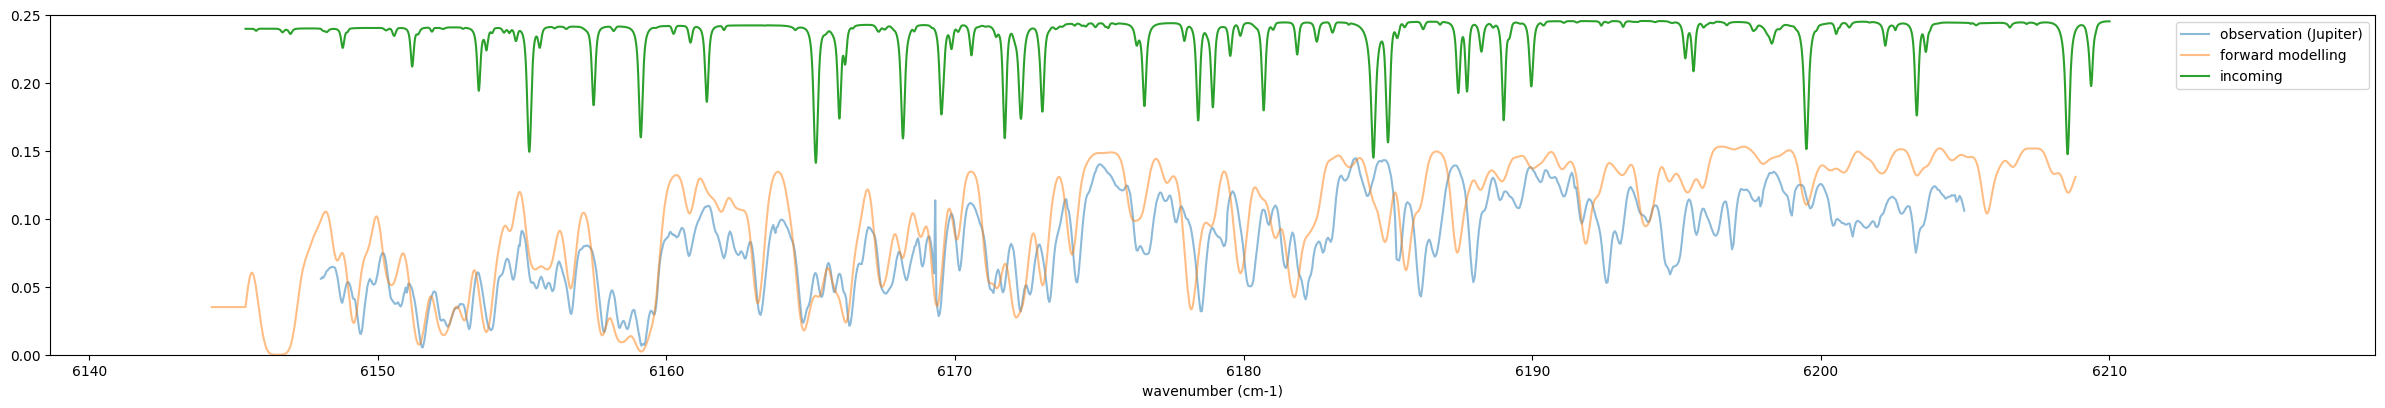

In [94]:
fig = plt.figure(figsize=(30,15))
ax = fig.add_subplot(311)
plt.plot(unus_analysis,spec_analysis/np.median(spec_analysis)*0.08,alpha=0.5,label="observation (Jupiter)")
plt.plot(nus,Fr_samp,alpha=0.5,label="forward modelling")
plt.plot(nus*(1-vpercp_only_show_solar),incoming_flux, label="incoming")
plt.legend()
plt.xlim(np.min(unus_order[1]),np.max(unus_order[1]))
plt.ylim(0.0,0.25)

plt.xlabel("wavenumber (cm-1)")
plt.savefig("Jupiter_forward_nir1.png")
plt.show()

In [35]:
nusjax = jnp.array(nus)
nusjax_solar = jnp.array(nus_solar)
solspecjax = jnp.array(solspec)


In [99]:
from exojax.utils.instfunc import resolution_to_gaussian_std


def wavenumber_polynomial_conversion(unus, coeff, nus0):
    power = np.array(range(1, len(coeff) + 1))
    nus_corr = np.sum(coeff[:, None] * (unus - nus0) ** power[:, None], axis=0) + nus0
    return nus_corr


# 2nd order
# optpar_init = np.array([0.0,0.91,0.0])
# multiple_factor = np.array([1.0,1.0,0.001])
# addition_factor = np.array([6167.0,0.0,0.0])

# vrv, nu0, coeff1, coeff2, coeff3
optpar_init = np.array([0.0, 0.0, 0.91, 0.0, 0.0])
multiple_factor = np.array([1.0, 1.0, 1.0, 0.001, 0.0001])
addition_factor = np.array([0.0, 6170.0, 0.0, 0.0, 0.0])

sop = SopInstProfile(nus)


def cost_function(optpar):
    vrv, nus_corr = unpack_optpar(optpar)
    Fr_samp = compute_flux(vrv, nus_corr)
    cost = np.sum((spec_analysis / np.median(spec_analysis) * 0.08 - Fr_samp) ** 2)
    return cost


def compute_flux(vrv, nus_corr):
    vv = - 60.0 - vrv
    vpercp = (vrv + vv) / 300000

    # incoming_flux = np.ones(len(nus))*0.3
    incoming_flux = jnp.interp(nusjax, nusjax_solar * (1.0 + vpercp), solspecjax)
    Fr = art.run(
        dtau,
        single_scattering_albedo,
        asymmetric_parameter,
        reflectivity_surface,
        incoming_flux,
    )

    #res_inst = 19000.0
    res_inst = 18000.0
    #res_inst = 15000.0
    
    std = resolution_to_gaussian_std(res_inst)
    Fr_inst = sop.ipgauss(Fr, std)
    Fr_samp = sop.sampling(Fr_inst, vv, nus_corr)
    return Fr_samp


def unpack_optpar(optpar):
    opt = optpar * multiple_factor + addition_factor
    coeff = opt[2:]
    nus0 = opt[1]
    vrv = opt[0]
    nus_corr = wavenumber_polynomial_conversion(unus_analysis, coeff, nus0)
    return vrv, nus_corr


import jaxopt

In [100]:
from jaxopt import OptaxSolver
import optax
#adam = OptaxSolver(opt=optax.adam(1.e-2), fun=cost_function)
#res = adam.run(optpar_init)

maxiter = 200
solver = jaxopt.LBFGS(fun=cost_function, maxiter=maxiter)
res = solver.run(optpar_init)


/home/kawahara/anaconda3/envs/myenv39/lib/python3.9/site-packages/jaxopt/_src/lbfgs.py:119: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  fun = lambda leaf: jnp.zeros((history_size,) + leaf.shape, dtype=leaf.dtype)
/home/kawahara/anaconda3/envs/myenv39/lib/python3.9/site-packages/jaxopt/_src/lbfgs.py:119: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  fun = lambda leaf: jnp.zeros((history_size,) + leaf.shape, dtype=leaf.dtype)


In [103]:
res[0]

Array([-0.01083821, -7.2409744 ,  0.99704784, -0.83384496,  0.04215651],      dtype=float32)

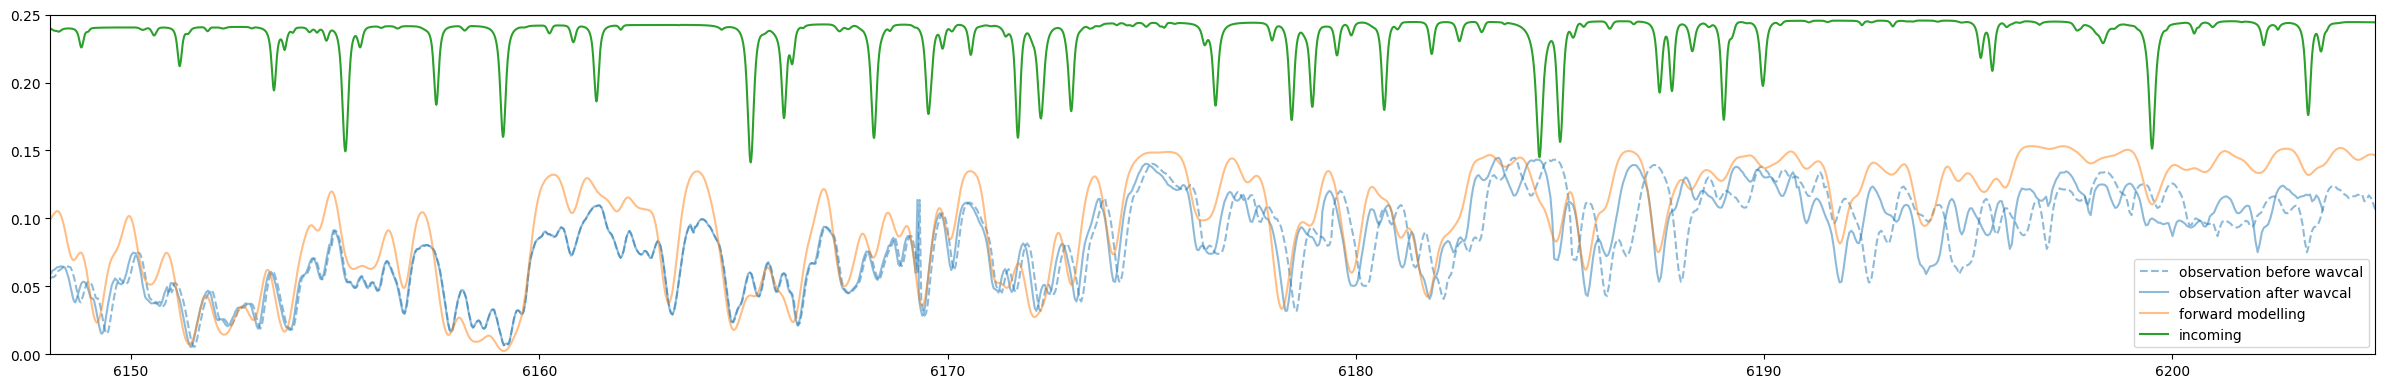

In [104]:
vrv, nus_corr = unpack_optpar(res[0])
F_samp = compute_flux(vrv, nus_corr)
fig = plt.figure(figsize=(30,15))
ax = fig.add_subplot(311)
plt.plot(unus_analysis,spec_analysis/np.median(spec_analysis)*0.08,alpha=0.5,label="observation before wavcal", color="C0",ls="dashed")
plt.plot(nus_corr,spec_analysis/np.median(spec_analysis)*0.08,alpha=0.5,label="observation after wavcal", color="C0")

plt.plot(nus,Fr_samp,alpha=0.5,label="forward modelling",color="C1")
plt.plot(nus*(1-vpercp_only_show_solar),incoming_flux, label="incoming",color="C2")
plt.legend()
plt.xlim(np.min(unus_analysis),np.max(unus_analysis))
plt.ylim(0.0,0.25)
plt.show()

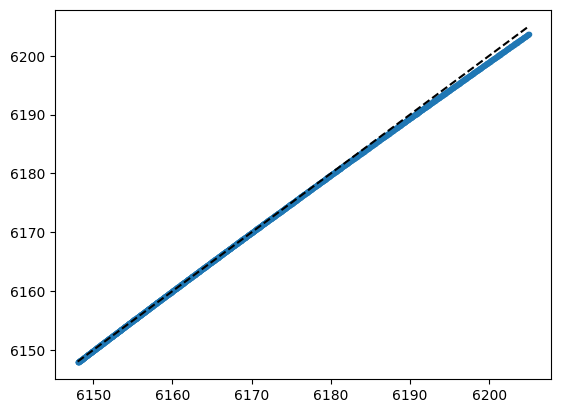

In [105]:
plt.plot(unus_analysis, nus_corr,".")   
plt.plot([unus_analysis[0],unus_analysis[-1]],[unus_analysis[0],unus_analysis[-1]],"k--") 

In [106]:
np.savetxt("jupiter_corrected.dat",np.array([nus_corr,spec_analysis/np.median(spec_analysis)*0.08]).T)